In [1]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
from brainspace.plotting import plot_hemispheres
from brainspace import mesh
import nibabel as nib
from matplotlib import cm
from matplotlib.colors import ListedColormap
from brainspace.utils.parcellation import map_to_labels
import hcp_utils as hcp
from mlxtend.evaluate import permutation_test
color_m = cm.get_cmap('prism', 91)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


## Markov Parcellation 

In [2]:
macaque_rh = mesh.mesh_io.read_surface('../data/macaque_data/surf/spec/MacaqueYerkes19.R.inflated.32k_fs_LR.surf.gii')
macaque_lh = mesh.mesh_io.read_surface('../data/macaque_data/surf/spec/MacaqueYerkes19.L.inflated.32k_fs_LR.surf.gii')

In [3]:
markov = '../data/markov.csv'
markov = genfromtxt(markov)
markov_64k = markov.copy()
markov_64k[np.where(markov_64k==0)]=np.nan

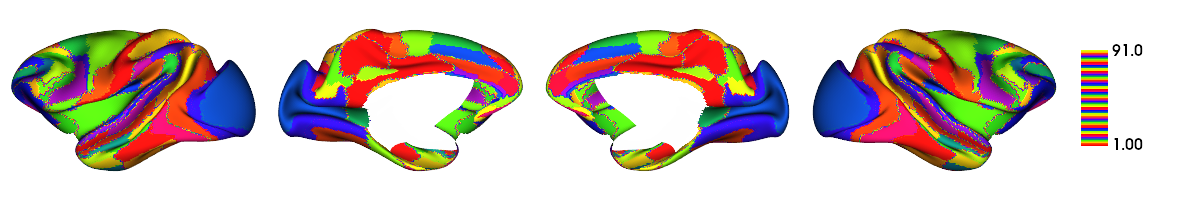

In [4]:
plot_hemispheres(macaque_lh, macaque_rh, array_name = markov_64k,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = color_m, color_bar = True,
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/fig_4-markov_parcels.svg',transparent_bg=True,scale=(2,2))
plot_hemispheres(macaque_lh, macaque_rh, array_name = markov_64k,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = color_m, color_bar = True,
                 interactive = False, zoom = 1.5, embed_nb = True)

### projection of human Cole-Anticevic networks to the macaque surface

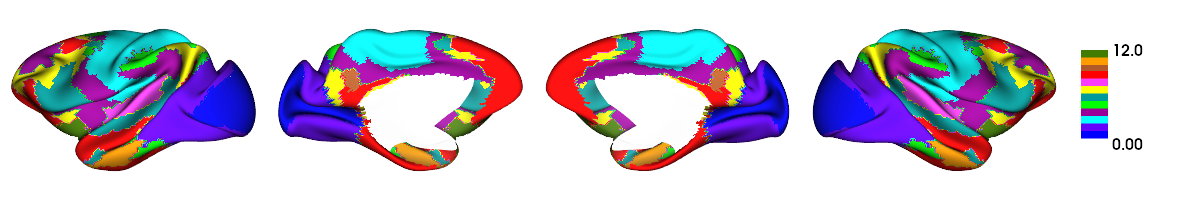

In [5]:
cmap = ListedColormap(np.vstack((list(hcp.ca_network['rgba'].values()))))

a = nib.load('../data/Ting/Glasser2016_language/L.HCP_MMP_P210.human-to-monkey.32k_fs_LR.label.gii').agg_data()
ca = np.array(pd.read_csv('../data/ca_glasser_network.csv',header=None))[:,0].astype(float)
color = ca[:180]

mask = a != 0
ca_macaque = map_to_labels(color, a, mask=mask)
ca_macaque[ca_macaque==0]=np.nan

plot_hemispheres(macaque_lh, macaque_rh, array_name = np.concatenate((ca_macaque,ca_macaque)),
                 nan_color = (1,1,1,0.1),size = (1200, 200),
                 cmap = cmap, color_bar = True, color_range = (0,12),
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/fig_4/ca_macaque.svg',transparent_bg=True,scale=(2,2))
plot_hemispheres(macaque_lh, macaque_rh, array_name = np.concatenate((ca_macaque,ca_macaque)),
                 nan_color = (1,1,1,0.1),size = (1200, 200),
                 cmap = cmap, color_bar = True, color_range = (0,12),
                 interactive = False, zoom = 1.5, embed_nb = True)

### macaque gradients of functional connectivity (LL, template space )

In [7]:
group = np.array(pd.read_csv('../data/data_results/macaque/group_grad_LL.csv',header = None))[:,:3]

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

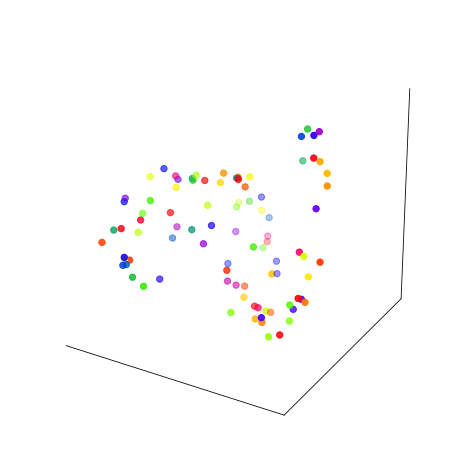

In [9]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.gca().patch.set_facecolor('white')
ax.w_xaxis.set_pane_color((1, 1, 1, 0))
ax.w_yaxis.set_pane_color((1, 1, 1, 0))
ax.w_zaxis.set_pane_color((1, 1, 1, 0))
#ax.set_xticks(np.arange(-0.12, 0.12, 0.04))
#ax.set_yticks(np.arange(-0.12, 0.12, 0.04))
#ax.set_zticks(np.arange(-0.12, 0.12, 0.04))
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.grid(False)
ax.scatter(group[:,0], group[:,1], group[:,2], s = 40, c = range(91), cmap=color_m, marker = 'o')
fig.savefig('../figures/fig_4_ll_3d_macaque.svg')

In [10]:
from brainspace.utils.parcellation import map_to_labels
labeling_l = markov[:32492]
labeling_r = markov[32492:]
mymask_l = labeling_l != 0         
mymask_r = labeling_r != 0     

In [11]:
ll_group = [None] * 3

for i in range(3):
    ll_group[i] = np.concatenate((map_to_labels(group[:,i], labeling_l, mask=mymask_l),
                                  map_to_labels(group[:,i], labeling_l, mask=mymask_l)))
    ll_group[i][ll_group[i]==0] = np.nan

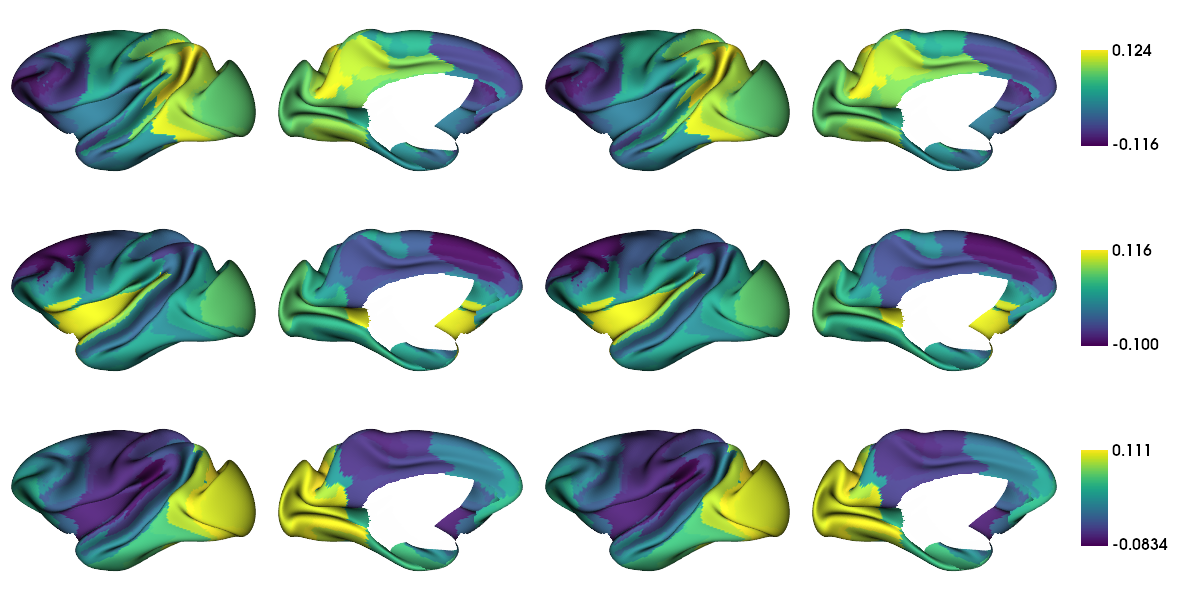

In [12]:
plot_hemispheres(macaque_lh, macaque_lh, array_name = ll_group,
                 nan_color = (1,1,1,0.01),size = (1200, 600),
                 cmap = 'viridis', color_bar = True,#color_range=(-0.12,0.12),
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/fig_4_ll_g123.svg',transparent_bg=True,scale=(2,2))
plot_hemispheres(macaque_lh, macaque_lh, array_name = ll_group,
                 nan_color = (1,1,1,0.01),size = (1200, 600),
                 cmap = 'viridis', color_bar = True, #color_range=(-0.12,0.12),
                 interactive = False, zoom = 1.5, embed_nb = True)

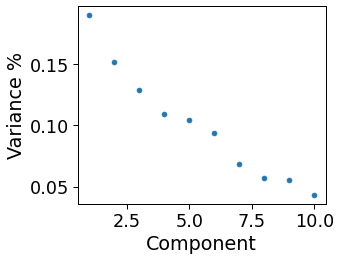

In [13]:
import seaborn as sns

sns.set_context("paper", font_scale = 2)
fig, ax = plt.subplots(1, figsize=(5, 4))
variance = np.array(pd.read_csv('../data/data_results/macaque/group_grad_LL_lambdas.csv',header=None))
explain = variance/np.sum(variance)
ax.scatter(range(1,11), explain)
ax.set_xlabel('Component')
ax.set_ylabel('Variance %')
fig.tight_layout()
plt.show()
fig.savefig('../figures/fig_4_variance.svg')

## mean asymmetry index (AI) of macaque G1

In [14]:
intramean = np.array(pd.read_csv('../data/data_results/macaque/macaque_91_gradient_intra_mean.csv',header=None))
intermean = np.array(pd.read_csv('../data/data_results/macaque/macaque_91_gradient_inter_mean.csv',header=None))

In [15]:
intra_g1 = np.concatenate((map_to_labels(intramean[:,0], labeling_l, mask=mymask_l),
                           map_to_labels(-intramean[:,0], labeling_r, mask=mymask_r)))
intra_g2 = np.concatenate((map_to_labels(intramean[:,1], labeling_l, mask=mymask_l),
                           map_to_labels(-intramean[:,1], labeling_r, mask=mymask_r)))
intra_g3 = np.concatenate((map_to_labels(intramean[:,2], labeling_l, mask=mymask_l),
                           map_to_labels(-intramean[:,2], labeling_r, mask=mymask_r)))
inter_g1 = np.concatenate((map_to_labels(intermean[:,0], labeling_l, mask=mymask_l),
                           map_to_labels(-intermean[:,0], labeling_r, mask=mymask_r)))
inter_g2 = np.concatenate((map_to_labels(intermean[:,1], labeling_l, mask=mymask_l),
                           map_to_labels(-intermean[:,1], labeling_r, mask=mymask_r)))
inter_g3 = np.concatenate((map_to_labels(intermean[:,2], labeling_l, mask=mymask_l),
                           map_to_labels(-intermean[:,2], labeling_r, mask=mymask_r)))

intra_g1[np.where(intra_g1==0)]=np.nan
intra_g2[np.where(intra_g2==0)]=np.nan
intra_g3[np.where(intra_g3==0)]=np.nan
inter_g1[np.where(inter_g1==0)]=np.nan
inter_g2[np.where(inter_g2==0)]=np.nan
inter_g3[np.where(inter_g3==0)]=np.nan

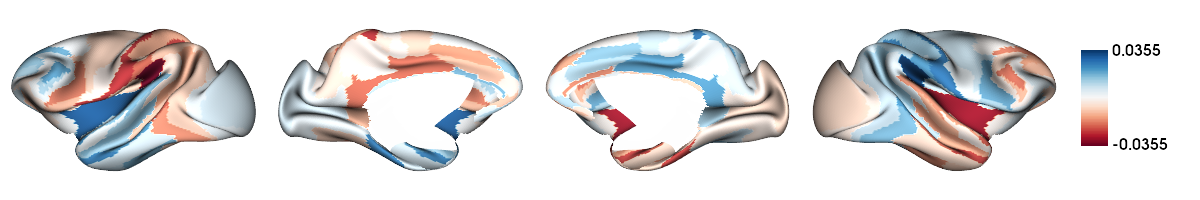

In [16]:
plot_hemispheres(macaque_lh, macaque_rh, array_name = intra_g1,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'RdBu', color_bar = True,
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/fig_4_intra_g1_mean.svg',transparent_bg=True,scale=(2,2))
plot_hemispheres(macaque_lh, macaque_rh, array_name = intra_g1,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'RdBu', color_bar = True,
                 interactive = False, zoom = 1.5, embed_nb = True)

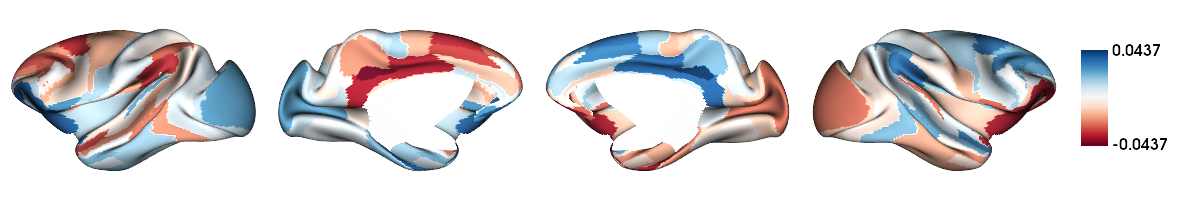

In [17]:
plot_hemispheres(macaque_lh, macaque_rh, array_name = inter_g1,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'RdBu', color_bar = True,
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/fig_4_inter_g1_mean.svg',transparent_bg=True,scale=(2,2))
plot_hemispheres(macaque_lh, macaque_rh, array_name = inter_g1,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'RdBu', color_bar = True,
                 interactive = False, zoom = 1.5, embed_nb = True)

## Cohen's d in macaques and humans

In [18]:
macaque = pd.read_csv('../data/data_results/macaque/macaque_asymmetric_gradients_stats.csv')

In [19]:
# compute Cohen's d across 19 macaque
macaque['intra_g1_d']=macaque['intra_g1_t']/pow(19, 0.5)
macaque['inter_g1_d']=macaque['inter_g1_t']/pow(19, 0.5)


In [20]:
intra_g1_m = np.concatenate((map_to_labels(macaque['intra_g1_d'], labeling_l, mask=mymask_l),
                                map_to_labels(-macaque['intra_g1_d'], labeling_r, mask=mymask_r)))

inter_g1_m = np.concatenate((map_to_labels(macaque['inter_g1_d'], labeling_l, mask=mymask_l),
                                map_to_labels(-macaque['inter_g1_d'], labeling_r, mask=mymask_r)))

intra_g1_m[np.where(intra_g1_m==0)]=np.nan
inter_g1_m[np.where(inter_g1_m==0)]=np.nan


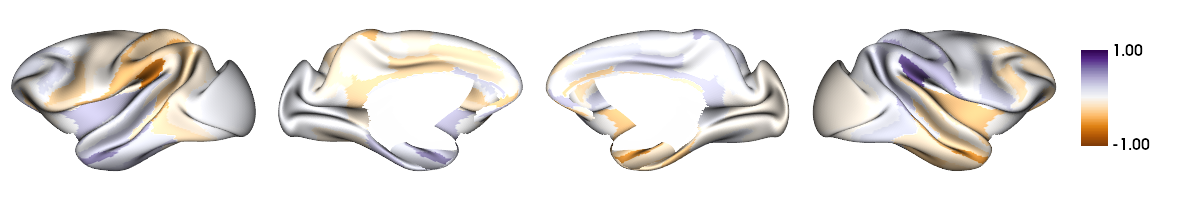

In [21]:
plot_hemispheres(macaque_lh, macaque_rh, array_name = intra_g1_m,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'PuOr', color_bar = True, color_range = (-1,1),
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/fig_4_intra_g1_cohen_macaque.svg',transparent_bg=True,scale=(2,2))
plot_hemispheres(macaque_lh, macaque_rh, array_name = intra_g1_m,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'PuOr', color_bar = True, color_range = (-1,1),
                 interactive = False, zoom = 1.5, embed_nb = True)

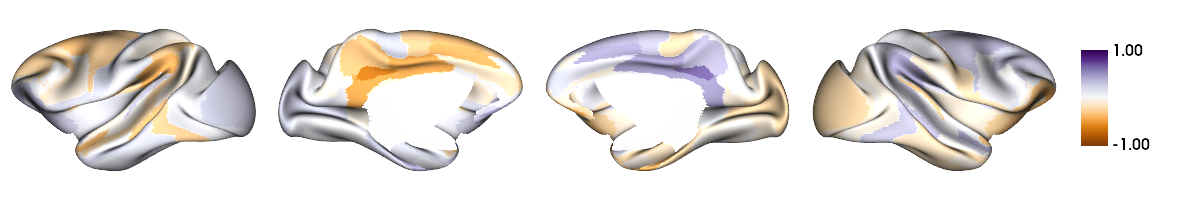

In [22]:
plot_hemispheres(macaque_lh, macaque_rh, array_name = inter_g1_m,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'PuOr', color_bar = True, color_range = (-1,1),
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/fig_4_inter_g1_cohen_macaque.svg',transparent_bg=True,scale=(2,2))
plot_hemispheres(macaque_lh, macaque_rh, array_name = inter_g1_m,
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'PuOr', color_bar = True, color_range = (-1,1),
                 interactive = False, zoom = 1.5, embed_nb = True)

###  Human data aligned to macaque -> Cohen's d

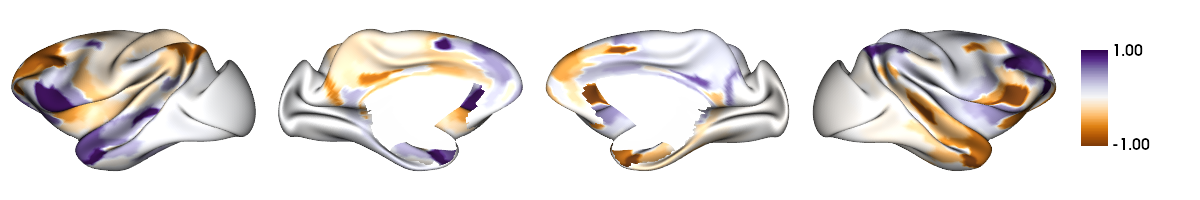

In [23]:
l_cohen_intra_hm = nib.load('../data/Ting/aligned_20210409/lh.cohen_LR_intra_human.human-to-monkey.32k_fs_LR.nii.gz').get_fdata()[:,0][:,0]
r_cohen_intra_hm = nib.load('../data/Ting/aligned_20210409/rh.cohen_LR_intra_human.human-to-monkey.32k_fs_LR.nii.gz').get_fdata()[:,0][:,0]
cohen_intra_hm = np.concatenate((l_cohen_intra_hm,r_cohen_intra_hm))
cohen_intra_hm[cohen_intra_hm==0]=np.nan
cohen_intra_hm = [cohen_intra_hm[:,0],cohen_intra_hm[:,1],cohen_intra_hm[:,2]]

plot_hemispheres(macaque_lh, macaque_rh, array_name = cohen_intra_hm[0],
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'PuOr', color_bar = True, color_range = (-1,1),
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/fig_4_intra_cohen_g1_hm.svg',transparent_bg=True,scale=(2,2))
plot_hemispheres(macaque_lh, macaque_rh, array_name = cohen_intra_hm[0],
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'PuOr', color_bar = True, color_range = (-1,1),
                 interactive = False, zoom = 1.5, embed_nb = True)

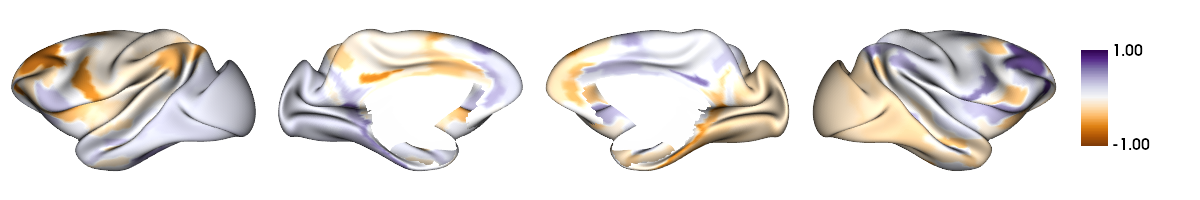

In [24]:
l_cohen_inter_hm = nib.load('../data/Ting/aligned_20210409/lh.cohen_LR_inter_human.human-to-monkey.32k_fs_LR.nii.gz').get_fdata()[:,0][:,0]
r_cohen_inter_hm = nib.load('../data/Ting/aligned_20210409/rh.cohen_LR_inter_human.human-to-monkey.32k_fs_LR.nii.gz').get_fdata()[:,0][:,0]
cohen_inter_hm = np.concatenate((l_cohen_inter_hm,r_cohen_inter_hm))
cohen_inter_hm[cohen_inter_hm==0]=np.nan
cohen_inter_hm = [cohen_inter_hm[:,0],cohen_inter_hm[:,1],cohen_inter_hm[:,2]]

plot_hemispheres(macaque_lh, macaque_rh, array_name = cohen_inter_hm[0],
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'PuOr', color_bar = True, color_range = (-1,1),
                 interactive = False, zoom = 1.5, embed_nb = True,
                 screenshot=True, filename='../figures/fig_4_inter_cohen_g1_hm.svg',transparent_bg=True,scale=(2,2))
plot_hemispheres(macaque_lh, macaque_rh, array_name = cohen_inter_hm[0],
                 nan_color = (1,1,1,0.01),size = (1200, 200),
                 cmap = 'PuOr', color_bar = True, color_range = (-1,1),
                 interactive = False, zoom = 1.5, embed_nb = True)

### scatter plots G1 (human) vs G1 (macaque), intra-hemisphere

0.23806338588947287 0.012987012987012988


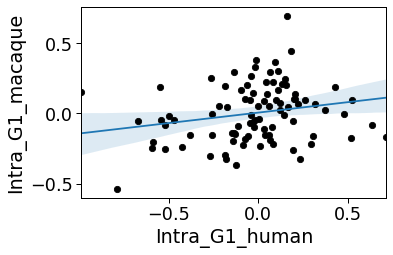

In [34]:
import statistics
from scipy import stats

sns.set_context("paper", font_scale = 2)
x, y = cohen_intra_hm[0][:32492], intra_g1_m[:32492]
x[np.where(np.isnan(x) == True)]=0
y[np.where(np.isnan(y) == True)]=0

newx = [None] * 91
newy = [None] * 91
for i in range(91):
    newx[i] = -statistics.mean(x[markov[:32492]==i+1])
    newy[i] = -statistics.mean(y[markov[:32492]==i+1])
    
f  = sns.regplot(newx,newy,scatter_kws={'s': 1})
f.scatter(newx, newy, s=40, c = 'black')
f.set_xlabel('Intra_G1_human')
f.set_ylabel('Intra_G1_macaque')
f.grid(False)
f=f.get_figure()
f.tight_layout()
f.savefig('../figures/fig_4_corr_intra_g1_g1.svg')

p_value = permutation_test(x=newx, y=newy,
                           method='approximate', num_rounds=1000,
                           func=lambda x, y: np.array(stats.spearmanr(x,y)[0]))

print(stats.spearmanr(newx,newy)[0], p_value)

### scatter plots G1 (human) vs G1 (macaque), inter-hemisphere

0.3776875298614429 0.001998001998001998


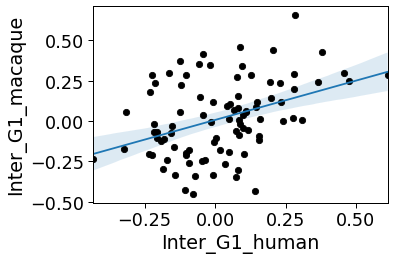

In [38]:
sns.set_context("paper", font_scale = 2)
x, y = cohen_inter_hm[0][:32492], inter_g1_m[:32492]
x[np.where(np.isnan(x) == True)]=0
y[np.where(np.isnan(y) == True)]=0

newx = [None] * 91
newy = [None] * 91
for i in range(91):
    newx[i] = -statistics.mean(x[markov[:32492]==i+1])
    newy[i] = -statistics.mean(y[markov[:32492]==i+1])
f  = sns.regplot(newx,newy,scatter_kws={'s': 1})
f.scatter(newx, newy, s=40, c = 'black')
f.set_xlabel('Inter_G1_human')
f.set_ylabel('Inter_G1_macaque')
f.grid(False)
f=f.get_figure()
f.tight_layout()
f.savefig('../figures/fig_4_corr_inter_g1_g1.svg')

p_value = permutation_test(x=newx, y=newy,
                           method='approximate', num_rounds=1000,
                           func=lambda x, y: np.array(stats.spearmanr(x,y)[0]))

print(stats.spearmanr(newx,newy)[0] ,p_value)

## Comparison between macaques and humans in Cohen’s d of asymmetry of G1.
#### The projection of human Cole-Anticevic networks

In [39]:
labels = ['Language','Default','Ventral-Multimodal','Primary Visual',
          'Secondary Visual','Somatomotor','Orbito-Affective','Dorsal-attention',
          'Posterior-Multimodal','Auditory','Cingulo-Opercular','Frontoparietal'][::-1]

color_h = [[0.      , 0.603922, 0.603922, 1.      ],
          [1., 0., 0., 1.],
          [1.      , 0.611765, 0.      , 1.      ],
          [0., 0., 1., 1.],
          [0.392157, 0.      , 1.      , 1.      ],
          [0., 1., 1., 1.],
          [0.254902, 0.486275, 0.      , 1.      ],
          [0., 1., 0., 1.],
          [0.694118, 0.34902 , 0.156863, 1.      ],
          [0.976471, 0.239216, 0.984314, 1.      ],
          [0.6, 0. , 0.6, 1. ],
          [1., 1., 0., 1.]][::-1]
color_m = [[0.      , 0.603922, 0.603922, 0.3      ],
          [1., 0., 0., 0.3],
          [1.      , 0.611765, 0.      , 0.3      ],
          [0., 0., 1., 0.3],
          [0.392157, 0.      , 1.      , 0.3      ],
          [0., 1., 1., 0.3],
          [0.254902, 0.486275, 0.      , 0.3      ],
          [0., 1., 0., 0.3],
          [0.694118, 0.34902 , 0.156863, 0.3      ],
          [0.976471, 0.239216, 0.984314, 0.3      ],
          [0.6, 0. , 0.6, 0.3 ],
          [1., 1., 0., 0.3]][::-1]

rank=[5,8,10,0,1,2,11,4,9,7,3,6]

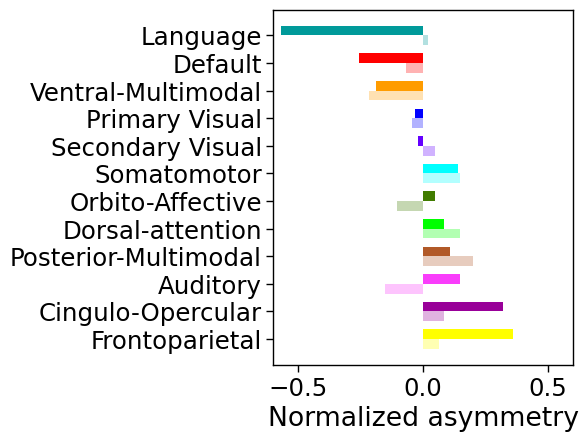

In [40]:
#intra

macaque_12 = [None] * 12
hm_12 = [None] * 12

for i in range(12):
    macaque_12[i] = -np.mean(intra_g1_m[:32492][ca_macaque==rank[i]+1][~np.isnan(intra_g1_m[:32492][ca_macaque==rank[i]+1])])
    hm_12[i] = -np.mean(cohen_intra_hm[0][:32492][ca_macaque==rank[i]+1][~np.isnan(cohen_intra_hm[0][:32492][ca_macaque==rank[i]+1])])

y = np.arange(len(labels))
width = 0.35
plt.rcdefaults()
sns.set_context("paper", font_scale = 2)
fig, ax = plt.subplots()
rects1 = ax.barh(y + width/2, hm_12[::-1], width, 
                 label='Humans',color=color_h)
rects2 = ax.barh(y - width/2, macaque_12[::-1], width, 
                 label='Macaques',color=color_m)
ax.set_xlabel('Normalized asymmetry')
ax.set_xlim(-0.6,0.6,0.3)
ax.set_yticks(y)
ax.set_yticklabels(labels)
#ax.yaxis.tick_right()
#ax.legend()

fig.tight_layout()
fig.savefig('../figures/fig_4_com_intra_g1.svg')

plt.show()

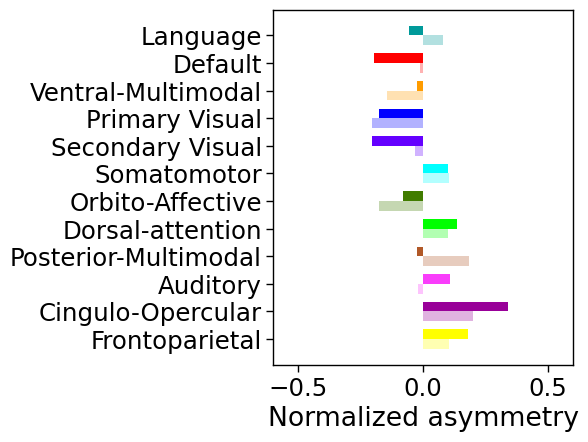

In [41]:
#inter

macaque_12 = [None] * 12
hm_12 = [None] * 12

for i in range(12):
    macaque_12[i] = -np.mean(inter_g1_m[:32492][ca_macaque==rank[i]+1][~np.isnan(inter_g1_m[:32492][ca_macaque==rank[i]+1])])
    hm_12[i] = -np.mean(cohen_inter_hm[0][:32492][ca_macaque==rank[i]+1][~np.isnan(cohen_inter_hm[0][:32492][ca_macaque==rank[i]+1])])

y = np.arange(len(labels))
width = 0.35
plt.rcdefaults()
sns.set_context("paper", font_scale = 2)
fig, ax = plt.subplots()
rects1 = ax.barh(y + width/2, hm_12[::-1], width, 
                 label='Humans',color=color_h)
rects2 = ax.barh(y - width/2, macaque_12[::-1], width, 
                 label='Macaques',color=color_m)
ax.set_xlabel('Normalized asymmetry')
ax.set_xlim(-0.6,0.6,0.3)
ax.set_yticks(y)
ax.set_yticklabels(labels)
#ax.yaxis.tick_right()
#ax.legend()

fig.tight_layout()
fig.savefig('../figures/fig_4_com_inter_g1.svg')

plt.show()